# 32: Denoising Autoencoder (MNIST)

### 🎯 Objective
This notebook builds a **Denoising Autoencoder**. We will take MNIST images, purposefully ruin them with severe random noise, and train a neural network to reconstruct the original, clean images. This teaches the network to separate "signal" (the digit) from "noise" (the static).

### 📚 Key Concepts
- **Autoencoder:** A network trained to copy its input to its output ($x \to \hat{x}$) through a bottleneck.
- **Bottleneck (Latent Space):** The middle layer with fewer neurons than the input. This forces compression.
- **Denoising:** Training with inputs $\tilde{x} = x + \text{noise}$ but targets $y = x$.
- **Reconstruction Loss:** Usually MSE, measuring the difference between the cleaned output and the original input.

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg') # Makes plots look sharper

/tmp/ipython-input-1765408841.py:10: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg') # Makes plots look sharper


## Import and process the data

Standard MNIST data loading and preprocessing

In [2]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# don't need labels! Autoencoders are unsupervised (or self-supervised)
# We only care about the image data (columns 1 to end)
data = data[:,1:]

# normalize the data to a range of [0 1]
# This matches the output range of the Sigmoid activation function in the model
dataNorm = data / np.max(data)

# convert to tensor
dataT = torch.tensor( dataNorm ).float()

## Create the DL model

### **The Autoencoder Architecture**
We define a class `aenet`.
* **Input Layer:** Takes the flattened 784-pixel image.
* **Encoder:** Compresses the input from 784 $\to$ 250 $\to$ 50 units.
* **Latent Layer (Bottleneck):** The 50-unit layer. This forces the network to learn the most important features (compression).
* **Decoder:** Expands the representation back from 50 $\to$ 250 $\to$ 784.

**Key Detail:** The final activation is `torch.sigmoid` to ensure the output pixels are valid grayscale intensities between 0 and 1.

In [3]:
# create a class for the model
def createTheMNISTAE():

  class aenet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,250)

      ### encoder layer
      self.enc = nn.Linear(250,50)

      ### latent layer (The Bottleneck)
      # This is the most compressed representation of the image
      self.lat = nn.Linear(50,250)

      ### decoder layer
      self.dec = nn.Linear(250,784)

    # forward pass
    def forward(self,x):
      # Pass through encoder (compression)
      x = F.relu( self.input(x) )
      x = F.relu( self.enc(x) )
      x = F.relu( self.lat(x) )
      
      # Pass through decoder (reconstruction)
      # Sigmoid is used here to ensure output is in [0,1] range like the data
      y = torch.sigmoid( self.dec(x) ) 
      return y

  # create the model instance
  net = aenet()

  # loss function
  # MSELoss is appropriate because we are comparing continuous pixel values
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [5]:
# test the model with a bit of data to ensure shapes match
net,lossfun,optimizer = createTheMNISTAE()

X = dataT[:5,:]
yHat = net(X)

print(X.shape)    # Should be (5, 784)
print(yHat.shape) # Should be (5, 784) - Same size as input!

torch.Size([5, 784])
torch.Size([5, 784])


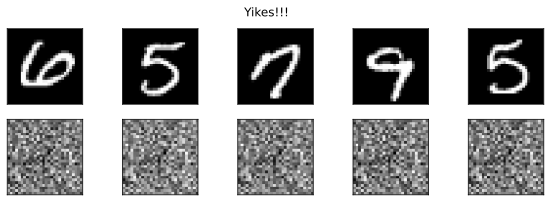

In [6]:
# let's see what the model did!
# Since the model is untrained, the output (bottom row) will be random noise/static.
fig,axs = plt.subplots(2,5,figsize=(10,3))

for i in range(5):
  axs[0,i].imshow(X[i,:].view(28,28).detach() ,cmap='gray')
  axs[1,i].imshow(yHat[i,:].view(28,28).detach() ,cmap='gray')
  axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
  axs[1,i].set_xticks([]), axs[1,i].set_yticks([])

plt.suptitle('Yikes!!!')
plt.show()

## Create a function that trains the model

### **Training Loop**
We train the model to minimize the **Reconstruction Loss** (MSE).
* **Goal:** Make `yHat` (output) look as close as possible to `X` (input).
* **Sampling:** We are manually selecting random batches of 32 images using `np.random.choice`.

In [7]:
def function2trainTheModel():

  # number of epochs
  numepochs = 10000

  # create a new model
  net,lossfun,optimizer = createTheMNISTAE()

  # initialize losses
  losses = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # select a random set of images (Batch size = 32)
    randomidx = np.random.choice(dataT.shape[0],size=32)
    X = dataT[randomidx,:]

    # forward pass and loss
    yHat = net(X)
    loss = lossfun(yHat,X) # Compare Input (X) directly to Output (yHat)

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # losses in this epoch
    losses[epochi] = loss.item()
  # end epochs

  # function output
  return losses,net

Final loss: 0.0064


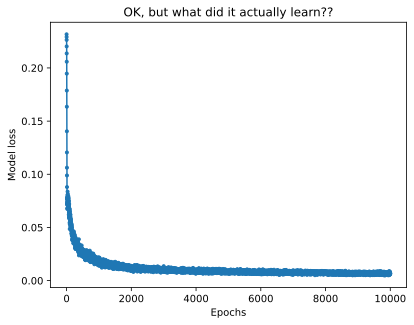

In [8]:
losses,net = function2trainTheModel()
print(f'Final loss: {losses[-1]:.4f}')

# visualize the losses
plt.plot(losses,'.-')
plt.xlabel('Epochs')
plt.ylabel('Model loss')
plt.title('OK, but what did it actually learn??')
plt.show()

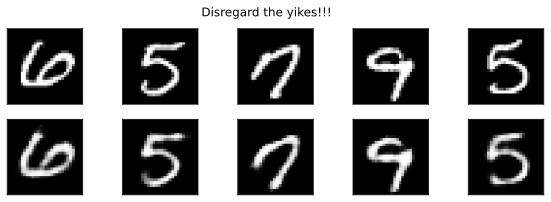

In [9]:
# Repeat the visualization when testing the model
X = dataT[:5,:]
yHat = net(X)


# let's see what the model did!
# The bottom row should now look like blurry versions of the top row.
fig,axs = plt.subplots(2,5,figsize=(10,3))

for i in range(5):
  axs[0,i].imshow(X[i,:].view(28,28).detach() ,cmap='gray')
  axs[1,i].imshow(yHat[i,:].view(28,28).detach() ,cmap='gray')
  axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
  axs[1,i].set_xticks([]), axs[1,i].set_yticks([])

plt.suptitle('Disregard the yikes!!!')
plt.show()

## Add noise to see a use case of an autoencoder

### **Denoising Demonstration**
This is the "magic" part.
1.  We take a clean image ($X$).
2.  We corrupt it with random noise ($X_{noise}$).
3.  We feed $X_{noise}$ into the autoencoder.

Even though the model was **never trained on noisy images**, it has learned what a "valid" digit looks like. It will attempt to interpret the noisy pixels as parts of a digit, effectively filtering out the randomness and outputting a cleaner version.

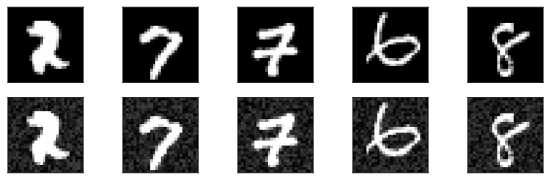

In [12]:
# grab a small set of images
X = dataT[10:20,:]

# add noise
# torch.rand_like creates random numbers between 0 and 1 with the same shape as X
Xnoise = X + torch.rand_like(X)/4

# clip at 1
# Ensure pixel values don't exceed 1.0 after adding noise
Xnoise[Xnoise>1] = 1


# show the noisy images
fig,axs = plt.subplots(2,5,figsize=(10,3))

for i in range(5):
  axs[0,i].imshow(X[i,:].view(28,28).detach() ,cmap='gray')
  axs[1,i].imshow(Xnoise[i,:].view(28,28).detach() ,cmap='gray')
  axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
  axs[1,i].set_xticks([]), axs[1,i].set_yticks([])

plt.show()

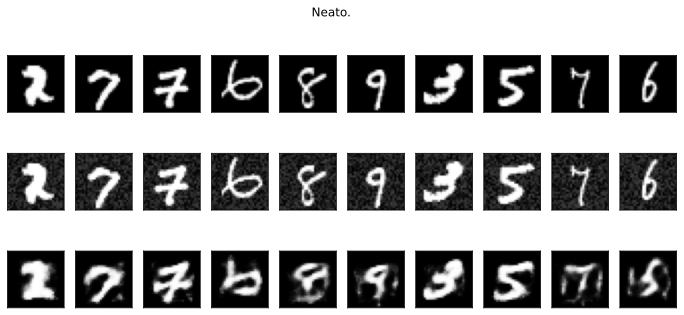

In [13]:
# run through the model
# Input: Noisy images -> Model -> Output: Denoised images
Y = net(Xnoise)


# show the noisy images
# Row 1: Original Clean
# Row 2: Noisy Input
# Row 3: Denoised Output
fig,axs = plt.subplots(3,10,figsize=(12,5))

for i in range(10):
  axs[0,i].imshow(X[i,:].view(28,28).detach() ,cmap='gray')
  axs[1,i].imshow(Xnoise[i,:].view(28,28).detach() ,cmap='gray')
  axs[2,i].imshow(Y[i,:].view(28,28).detach() ,cmap='gray')
  axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
  axs[1,i].set_xticks([]), axs[1,i].set_yticks([])
  axs[2,i].set_xticks([]), axs[2,i].set_yticks([])

plt.suptitle('Neato.')
plt.show()